In [8]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from careful_split import careful_split
from helpers import my_train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import smogn

from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

%matplotlib inline

In [237]:
ds = pd.read_csv('ds_tidy.csv', parse_dates=['date'])
ds.head()

,turma,date,student,topicos,component,relevance,learn,satisfaction,pace,tool,algorithm
0,6,2019-04-18,25,aplicações de clusterização de dados,Agrupamento,4,1,6,5,False,False
1,6,2019-04-18,25,MeanShift e DBSCAN,Agrupamento/Algoritmo/ML,4,2,6,5,False,True
2,6,2019-04-18,47,aplicações de clusterização de dados,Agrupamento,5,1,7,7,False,False
3,6,2019-04-18,47,MeanShift e DBSCAN,Agrupamento/Algoritmo/ML,5,2,7,7,False,True
4,6,2019-04-18,32,aplicações de clusterização de dados,Agrupamento,4,1,5,7,False,False


In [305]:
numerical_features = ['satisfaction']
categorical_features = ['relevance', 'pace']
predictors = numerical_features + categorical_features

In [306]:
ds['lesson'] = ds.date.astype(str) + '/' + ds.turma.astype(str)

In [307]:
subset_1, subset_2 = careful_split(ds)

In [308]:
data_train, data_test = my_train_test_split(subset_1)

In [309]:
if len(categorical_features) == 0:
    features = data_train[numerical_features]
elif len(numerical_features) == 0:
    dummies = pd.get_dummies(data_train[categorical_features].astype(str), drop_first=True)
    features = dummies
else:
    dummies = pd.get_dummies(data_train[categorical_features].astype(str), drop_first=True)
    features = pd.concat([data_train[numerical_features], dummies], axis=1)

In [310]:
X_train = features.to_numpy()
y_train = data_train.learn.to_numpy()

X_test = features.to_numpy()
y_test = data_train.learn.to_numpy()

In [311]:
params = {
    'n_estimators': [50, 100]
}

regressor = GridSearchCV(RandomForestRegressor(random_state=42), params)
model = regressor.fit(X_train, y_train)

In [312]:
model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
model.fit(X_train, y_train)

[22:36:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[22:36:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [313]:
y_pred = model.predict(X_test)

In [314]:
def r2_adjusted(r2, n, p):
    return 1 - (1 - r2) * (n-1) / (n-p-1)

In [315]:
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

r2 = r2_score(y_test, y_pred)
print(f'R2: {r2}')

n = len(y_test)
p = len(predictors)
print(f'R2 ajustado: {r2_adjusted(r2, n, p)}')

MSE: 0.5909306923568712
RMSE: 0.7687201651816292
MAE: 0.5815398533446668
R2: 0.19344311226486577
R2 ajustado: 0.19147590034356066


### X_test[0:10]

In [234]:
s = np.linspace(1,10)
a = model.predict(s.reshape(s.shape[0],-1))

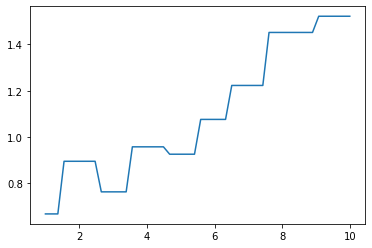

In [235]:
plt.plot(s,a)

Text(0.5, 1.0, 'Feature Importance')

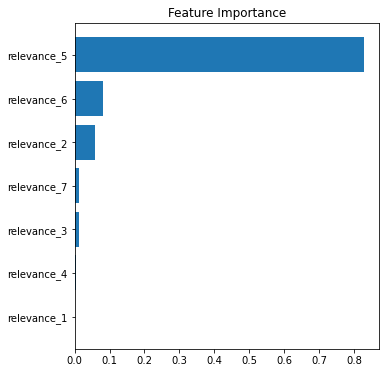

In [167]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features.columns)[sorted_idx])
plt.title('Feature Importance')

In [115]:
features.head()

,satisfaction,relevance_1,relevance_2,relevance_3,relevance_4,relevance_5,relevance_6,relevance_7,pace_10,pace_2,pace_5,pace_7
803,10,0,0,0,0,1,0,0,0,0,1,0
815,10,0,0,0,0,1,0,0,0,0,0,1
788,6,0,0,0,0,1,0,0,0,0,1,0
782,10,0,0,0,0,1,0,0,0,0,1,0
830,10,0,1,0,0,0,0,0,0,0,1,0


In [30]:
import lime
import lime.lime_tabular
# LIME has one explainer for all models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train,
    feature_names=features.columns,
    categorical_features=categorical_features,
    verbose=True,
    mode='regression')
# Out-of-the-box LIME cannot handle the requirement of XGBoost to use xgb.DMatrix() on the input data
model.predict(xgb.DMatrix(X_test))
expXGB = explainer.explain_instance(X_test, model.predict, num_features=5)
expXGB.show_in_notebook(show_table=True)

TypeError: can not initialize DMatrix from DMatrix

In [38]:
X_test_df = pd.DataFrame(data=X_test, columns=features.columns)

In [39]:
import shap
j = 0
explainerXGB = shap.TreeExplainer(model)
shap_values_XGB_test = explainerXGB.shap_values(X_test_df)
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test_df.iloc[[j]])

In [23]:
shap.initjs()

NameError: name 'shap' is not defined